In [8]:
import pandas as pd
from pathlib import Path

data_path = Path("C:/Users/marco/audit-risk-model/data/raw/transactions.csv")
df = pd.read_csv(data_path)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

feat = pd.read_csv("C:/Users/marco/audit-risk-model/data/processed/origin_account_features_scored.csv", index_col=0)
feat.head()

,txn_count,total_amount,avg_amount,std_amount,max_amount,min_amount,payment_ratio,transfer_ratio,cashout_ratio,debit_ratio,fraud_rate,amount_volatility,risk_score
nameOrig,,,,,,,,,,,,,
C1000008582,0.0,0.031563,315626.96,NaN,315626.96,315626.96,0.0,0.0,1.0,0.0,0.0,NaN,NaN
C1000009135,0.0,0.000385,3849.38,NaN,3849.38,3849.38,1.0,0.0,0.0,0.0,0.0,NaN,NaN
C1000012640,0.0,0.036753,367527.28,NaN,367527.28,367527.28,0.0,0.0,1.0,0.0,0.0,NaN,NaN
C1000018663,0.0,0.001245,12454.86,NaN,12454.86,12454.86,1.0,0.0,0.0,0.0,0.0,NaN,NaN
C1000022742,0.0,0.000237,2368.68,NaN,2368.68,2368.68,1.0,0.0,0.0,0.0,0.0,NaN,NaN


In [ ]:
# Group by origin account
group_col = "nameOrig"

agg = df.groupby(group_col).agg(
    txn_count=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    std_amount=("amount", "std"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min"),
    payment_ratio=("type", lambda x: (x == "PAYMENT").mean()),
    transfer_ratio=("type", lambda x: (x == "TRANSFER").mean()),
    cashout_ratio=("type", lambda x: (x == "CASH_OUT").mean()),
    debit_ratio=("type", lambda x: (x == "DEBIT").mean()),
    fraud_rate=("isFraud", "mean"),
)

agg["amount_volatility"] = agg["std_amount"] / agg["avg_amount"]

In [1]:
import pandas as pd
from pathlib import Path

processed_path = Path("C:/Users/marco/audit-risk-model/data/processed/origin_account_features.csv")
agg = pd.read_csv(processed_path, index_col=0)

agg.head()


,txn_count,total_amount,avg_amount,std_amount,max_amount,min_amount,payment_ratio,transfer_ratio,cashout_ratio,debit_ratio,fraud_rate,amount_volatility
nameOrig,,,,,,,,,,,,
C1000008582,1,315626.96,315626.96,NaN,315626.96,315626.96,0.0,0.0,1.0,0.0,0.0,NaN
C1000009135,1,3849.38,3849.38,NaN,3849.38,3849.38,1.0,0.0,0.0,0.0,0.0,NaN
C1000012640,1,367527.28,367527.28,NaN,367527.28,367527.28,0.0,0.0,1.0,0.0,0.0,NaN
C1000018663,1,12454.86,12454.86,NaN,12454.86,12454.86,1.0,0.0,0.0,0.0,0.0,NaN
C1000022742,1,2368.68,2368.68,NaN,2368.68,2368.68,1.0,0.0,0.0,0.0,0.0,NaN


In [2]:
from sklearn.preprocessing import MinMaxScaler

feat = agg.copy()

cols_to_scale = [
    "txn_count",
    "total_amount",
    "amount_volatility",
    "fraud_rate",
]

# Drop any columns that might be all NaN
cols_to_scale = [c for c in cols_to_scale if c in feat.columns]

scaler = MinMaxScaler()
feat[cols_to_scale] = scaler.fit_transform(feat[cols_to_scale])

weights = {
    "txn_count": 0.2,
    "total_amount": 0.2,
    "amount_volatility": 0.3,
    "fraud_rate": 0.3,
}

feat["risk_score"] = sum(
    feat[col] * w for col, w in weights.items() if col in feat.columns
)

feat.sort_values("risk_score", ascending=False).head(20)


,txn_count,total_amount,avg_amount,std_amount,max_amount,min_amount,payment_ratio,transfer_ratio,cashout_ratio,debit_ratio,fraud_rate,amount_volatility,risk_score
nameOrig,,,,,,,,,,,,,
C1250194175,1.0,0.045330,226651.345,319370.314369,452480.26,822.43,0.5,0.0,0.0,0.0,0.0,1.000000,0.509066
C838964826,1.0,0.037073,185365.795,257869.150532,367706.82,3024.77,0.5,0.0,0.5,0.0,0.0,0.986137,0.503256
C849745739,1.0,0.059302,296510.095,405366.463208,583147.47,9872.72,0.5,0.0,0.0,0.0,0.0,0.967587,0.502136
C1842781381,1.0,0.022491,112456.385,153053.354712,220681.45,4231.32,0.5,0.0,0.5,0.0,0.0,0.962856,0.493355
C1709295811,1.0,0.051540,257698.355,339450.251909,497725.93,17670.78,0.5,0.5,0.0,0.0,0.0,0.929048,0.489022
C1274691223,1.0,0.026111,130556.180,173256.548034,253067.06,8045.30,0.5,0.0,0.5,0.0,0.0,0.936639,0.486214
C1239049859,1.0,0.017155,85774.835,114204.964722,166529.94,5019.73,0.5,0.0,0.5,0.0,0.0,0.940027,0.485439
C1162717140,1.0,0.038426,192128.195,251766.903863,370154.28,14102.11,0.5,0.5,0.0,0.0,0.0,0.923773,0.484817
C199116739,1.0,0.029913,149565.235,194810.371877,287316.97,11813.50,0.5,0.0,0.5,0.0,0.0,0.917670,0.481284


In [3]:
feat["high_risk_flag"] = (feat["risk_score"] >= feat["risk_score"].quantile(0.8)).astype(int)
feat["high_risk_flag"].value_counts(normalize=True)


high_risk_flag
0    0.99998
1    0.00002
Name: proportion, dtype: float64

In [4]:
# Rank-based top 20% high risk
feat = feat.sort_values("risk_score", ascending=False)
n = int(len(feat) * 0.2)

feat["high_risk_flag"] = 0
feat.iloc[:n, feat.columns.get_loc("high_risk_flag")] = 1

feat["high_risk_flag"].value_counts(normalize=True)

high_risk_flag
0    0.800001
1    0.199999
Name: proportion, dtype: float64

In [5]:
cols = ["txn_count", "total_amount", "amount_volatility", "fraud_rate", "risk_score", "high_risk_flag"]

high = feat[feat["high_risk_flag"] == 1].head(10)[cols]
low = feat[feat["high_risk_flag"] == 0].head(10)[cols]

high, low

(             txn_count  total_amount  amount_volatility  fraud_rate  \
 nameOrig                                                              
 C1250194175        1.0      0.045330           1.000000         0.0   
 C838964826         1.0      0.037073           0.986137         0.0   
 C849745739         1.0      0.059302           0.967587         0.0   
 C1842781381        1.0      0.022491           0.962856         0.0   
 C1709295811        1.0      0.051540           0.929048         0.0   
 C1274691223        1.0      0.026111           0.936639         0.0   
 C1239049859        1.0      0.017155           0.940027         0.0   
 C1162717140        1.0      0.038426           0.923773         0.0   
 C199116739         1.0      0.029913           0.917670         0.0   
 C119887223         1.0      0.034774           0.899917         0.0   
 
              risk_score  high_risk_flag  
 nameOrig                                 
 C1250194175    0.509066               1  
 C838

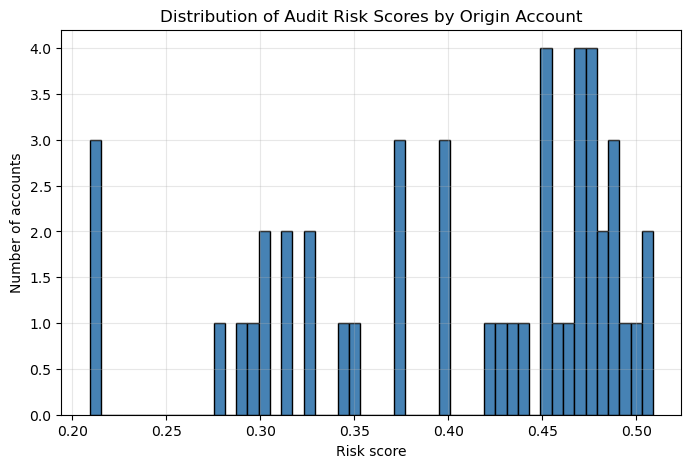

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(feat["risk_score"], bins=50, color="steelblue", edgecolor="black")
plt.title("Distribution of Audit Risk Scores by Origin Account")
plt.xlabel("Risk score")
plt.ylabel("Number of accounts")
plt.grid(alpha=0.3)
plt.show()


In [5]:
# Top 10 high-risk accounts
feat.sort_values("risk_score", ascending=False).head(10)[
    ["txn_count", "total_amount", "amount_volatility", "fraud_rate", "risk_score"]
]

# Bottom 10 low-risk accounts
feat.sort_values("risk_score", ascending=True).head(10)[
    ["txn_count", "total_amount", "amount_volatility", "fraud_rate", "risk_score"]
]


,txn_count,total_amount,amount_volatility,fraud_rate,risk_score
nameOrig,,,,,
C1710302637,1.0,0.024193,0.014647,0.0,0.209233
C675934000,1.0,0.060000,0.000000,0.0,0.212000
C1154669435,1.0,0.006036,0.043002,0.0,0.214108
C77405061,1.0,0.024893,0.238445,0.0,0.276512
C779875094,1.0,0.009647,0.292828,0.0,0.289778
C282214944,1.0,0.019177,0.308593,0.0,0.296413
C1081326121,1.0,0.051155,0.304638,0.0,0.301622
C1052471021,1.0,0.035304,0.318914,0.0,0.302735
C18060993,1.0,0.048176,0.341505,0.0,0.312087
